<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Design-HiC-experiment" data-toc-modified-id="Design-HiC-experiment-1">Design HiC experiment</a></span><ul class="toc-item"><li><span><a href="#Choose-restriction-enzyme" data-toc-modified-id="Choose-restriction-enzyme-1.1">Choose restriction enzyme</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-2">References</a></span></li></ul></div>

# Design HiC experiment

## Choose restriction enzyme

 - overhang
 - recognizable ligation site
 - homogeneous distribution
 - ph vs star activity
 - GC bias
 - ...

First we need to load the _Mouse_ genomic sequence:

In [1]:
from pytadbit.parsers.genome_parser import parse_fasta
from matplotlib import pyplot as plt

In [2]:
genome_seq = parse_fasta('genome/Mus_musculus-GRCm38.p6/Mus_musculus-GRCm38.p6.fa', 
                         reload_cache=True)

Parsing chr1
Parsing chr2
Parsing chr3
Parsing chr4
Parsing chr5
Parsing chr6
Parsing chr7
Parsing chr8
Parsing chr9
Parsing chr10
Parsing chr11
Parsing chr12
Parsing chr13
Parsing chr14
Parsing chr15
Parsing chr16
Parsing chr17
Parsing chr18
Parsing chr19
Parsing chrX
Parsing chrY
Parsing chrMT
saving genome in cache


We have loaded the full mouse genome, we can plot the size of each chromosome:

/home/fransua/.miniconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


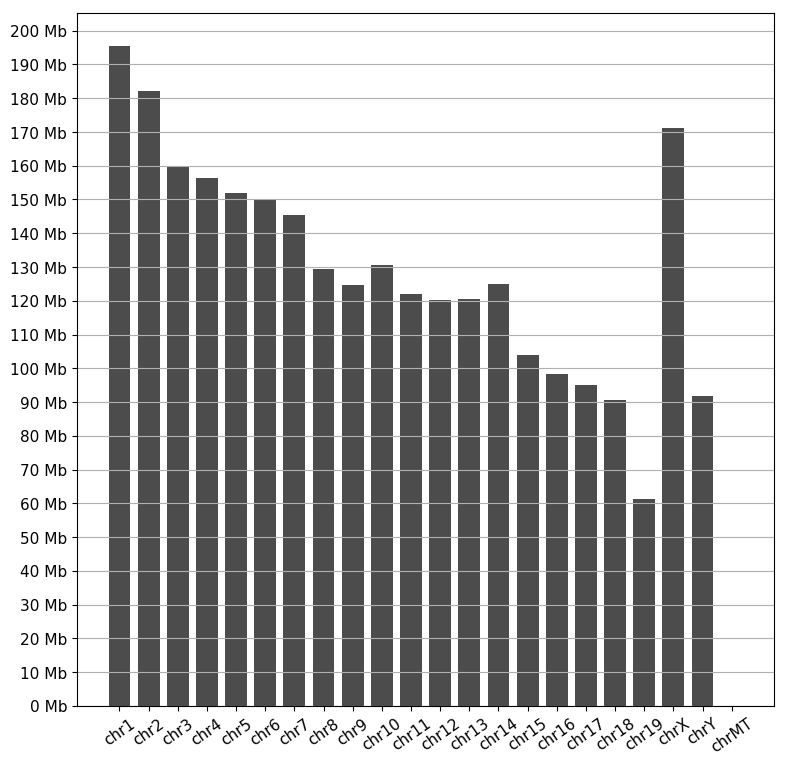

In [3]:
genome_lens = [len(genome_seq[c]) for c in genome_seq]
plt.bar(range(len(genome_seq)), [len(genome_seq[c]) for c in genome_seq], 
        color='k', alpha=0.7, width=0.75)
_ = plt.xticks([v for v in range(len(genome_seq))], genome_seq.keys(), rotation=35)
_ = plt.yticks([v for v in range(0, max(genome_lens) + 10000000, 10000000)],
               ['%d Mb' % (v / 1000000) for v in range(0, max(genome_lens) + 10000000, 10000000)])
plt.axes().yaxis.grid()
plt.show()

Then, we search for restriction enzyme sites in this sequence.

In [4]:
from pytadbit.mapping.restriction_enzymes import map_re_sites

frags_MboI    = map_re_sites('MboI'   , genome_seq, verbose=True)
frags_HindIII = map_re_sites('HindIII', genome_seq, verbose=True)
frags_NcoI    = map_re_sites('NcoI'   , genome_seq, verbose=True)

Found 6669655 RE sites
Found 849922 RE sites
Found 862336 RE sites


In [5]:
max_size = 30000
c0 = 'chr1'
v0 = 0
dists_MboI = []
for c1, v1 in [(c, v) for c in frags_MboI for p in frags_MboI[c] 
               for v in frags_MboI[c][p]]:
    if c1 == c0:
        diff = abs(v1 - v0)
        if diff < max_size:  # larger fragments are probably poorly assembled regions
            dists_MboI.append(diff)
    v0 = v1

v0 = 0
dists_HindIII = []
for c1, v1 in [(c, v) for c in frags_HindIII for p in frags_HindIII[c] 
               for v in frags_HindIII[c][p]]:
    if c1 == c0:
        diff = abs(v1 - v0)
        if diff < max_size:  # larger fragments are probably poorly assembled regions
            dists_HindIII.append(diff)
    v0 = v1

v0 = 0
dists_NcoI = []
for c1, v1 in [(c, v) for c in frags_NcoI for p in frags_NcoI[c] 
               for v in frags_NcoI[c][p]]:
    if c1 == c0:
        diff = abs(v1 - v0)
        if diff < max_size:  # larger fragments are probably poorly assembled regions
            dists_NcoI.append(diff)
    v0 = v1

/home/fransua/.miniconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


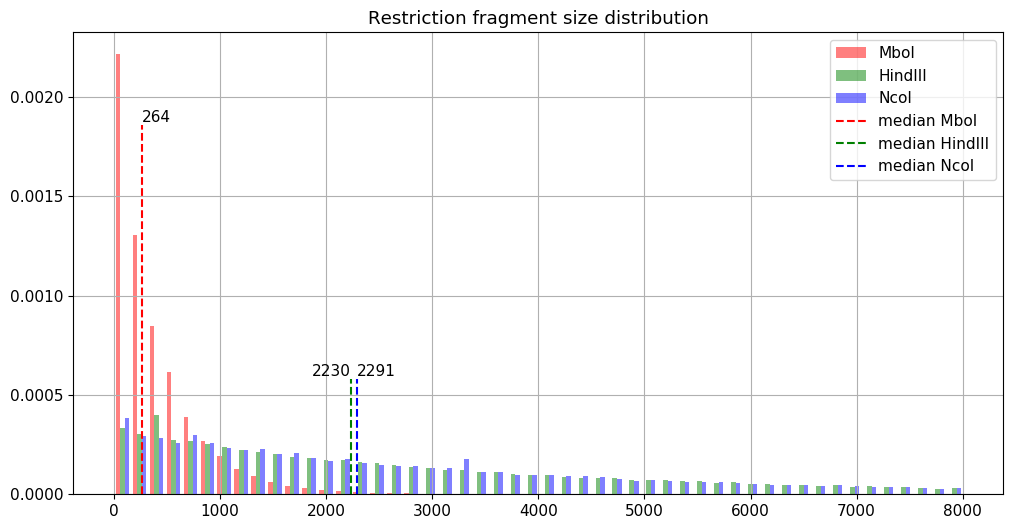

In [6]:
import numpy as np
plt.figure(figsize=(12, 6))
_ = plt.hist([dists_MboI, dists_HindIII, dists_NcoI], bins=50, color=['red', 'green', 'blue'], 
             alpha=0.5, label=['MboI', 'HindIII', 'NcoI'], range=(0, 8000), normed=True)
y0, y1 = plt.ylim()
plt.vlines(np.median(dists_MboI), y0, y1 * 0.8, color='red', linestyle='--',
          label='median MboI')
plt.vlines(np.median(dists_HindIII), y0, y1 * 0.25, color='green', linestyle='--',
          label='median HindIII')
plt.vlines(np.median(dists_NcoI)   , y0, y1 * 0.25, color='blue', linestyle='--',
          label='median NcoI')
plt.text(np.median(dists_MboI), y1 * 0.8, '%.0f' % np.median(dists_MboI), va='bottom', 
         ha='left')
plt.text(np.median(dists_HindIII), y1 * 0.25, '%.0f' % np.median(dists_HindIII), va='bottom', 
         ha='right')
plt.text(np.median(dists_NcoI)   , y1 * 0.25,'%.0f' % np.median(dists_NcoI)   , va='bottom', 
         ha='left')
plt.title('Restriction fragment size distribution')
plt.legend()
plt.grid()
plt.show()

# References

<a name="cite-ralph"/><sup>[^](#ref-1) </sup>Stadhouders R, Vidal E, Serra F, Di Stefano B et al. 2018. _Transcription factors orchestrate dynamic interplay between genome topology and gene regulation during cell reprogramming_.

<a name="cite-roguski2014dsrc"/><sup>[^](#ref-4) </sup>Roguski, \Lukasz and Deorowicz, Sebastian. 2014. _DSRC 2—Industry-oriented compression of FASTQ files_.



<!--bibtex
@article{le2014distinct,
  title={Distinct structural transitions of chromatin topological domains correlate with coordinated hormone-induced gene regulation},
  author={Le Dily, Fran{\c{c}}ois and Ba{\`u}, Davide and Pohl, Andy and Vicent, Guillermo P and Serra, Fran{\c{c}}ois and Soronellas, Daniel and Castellano, Giancarlo and Wright, Roni HG and Ballare, Cecilia and Filion, Guillaume and others},
  journal={Genes \& development},
  volume={28},
  number={19},
  pages={2151--2162},
  year={2014},
  publisher={Cold Spring Harbor Lab}
}
@article{roguski2014dsrc,
  title={DSRC 2—Industry-oriented compression of FASTQ files},
  author={Roguski, {\L}ukasz and Deorowicz, Sebastian},
  journal={Bioinformatics},
  volume={30},
  number={15},
  pages={2213--2215},
  year={2014},
  publisher={Oxford Univ Press}
}
-->